In [1]:
import pypyodbc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import matplotlib.patches as mpatches
import time

In [4]:
# connect to the database using pypyodbc
db_host = "192.168.100.35"
db_name = "AC35"
db_user = "dbreader"
db_password = "dbr3ader"

connection_string='DSN=MYMSSQL;DATABASE=AC35;UID=dbreader;PWD=dbr3ader'

db = pypyodbc.connect(connection_string)
crsr = db.cursor()

In [24]:
"""
this data needs to be hardcoded in everyday in order to ensure that the program can access the database properly

rr_i = round robin i
"""
rr1 = {1: ["USA", "FRA"], 2: ["SWE", "JPN"], 3: ["NZL", "FRA"], 4: ["SWE", "GBR"], 
                   5: ["USA", "NZL"], 6: ["JPN", "GBR"], 7: ["SWE", "FRA"], 8: ["USA", "GBR"], 
                   9: ["NZL", "JPN"], 10: ["USA", "SWE"], 11: ["NZL", "GBR"], 12: ["USA", "JPN"],
                   13: ["FRA", "GBR"], 14: ["SWE", "NZL"], 15: ["JPN", "FRA"]}

rr2 = {1: ["SWE", "NZL"], 2: ["USA", "FRA"], 3: ["SWE", "GBR"]}

round_robins = [rr1, rr2]

def get_competitor_info(rr_num, race_number):
    """
    function to return the relevant competitors in each round robin
    
    rr_num = round robin number (int)
    race_number = (int)
    """
    return(round_robins[rr_num - 1][race_number])
    

In [25]:
# map ACEA names to database names
db_names = {"NZL": "ETNZ", "USA": "ORACLE", "SWE": "ARTEMIS", "JPN": "JAPAN", "GBR": "GBR", "FRA": "FRANCE"}

In [26]:
def execute_query(q_string):
    """
    executes query on the database
    
    q_string = query (string)
    """
    return crsr.execute(q_string).fetchall()

def get_race_start(rr_number, race_number):
    """
    returns TS corresponding to the warning signal (3 minutes before the gun) of the relevant race
    
    return type (long)
    """
    competitors = ",".join(get_competitor_info(rr_number, race_number))
    q = "select startTS from [AC35].a.ranges where rangenotes like '%RACE {0} %({1})% Warning,%'".format(race_number, competitors)
    return execute_query(q)[0][0]

In [28]:
def get_speeds(rr_number, race_number, start, end):
    """
    rr_number: int corresponding to the round robin number
    race_number: int corresponding to the relevant race number
    start: seconds before the start, should be a negative number, must be in (-180, 0)
    end: seconds after the start, should be a positve number, must be in (0, End of Race)
    
    returns: Pandas Data Frame with timestep and sogs corresponding to both teams
    """
    race_start = get_race_start(rr_number, race_number)
    lb = race_start + (180 + start) * 1000 
    ub = race_start + (180 + end) * 1000
    
    boat1, boat2 = get_competitor_info(rr_number, race_number)
    db1 = db_names[boat1]
    db2 = db_names[boat2]
    
    query = ("select A.TS, A.V '{0} SOG', B.V '{1} SOG' from ("
             "(select SID, TS, V from [AC35].[d].[ACEA.{0}.SOG] where ts between {2} and {3}) A "
             "inner join "
             "(select SID, TS, V from [AC35].[d].[ACEA.{1}.SOG] where ts between {2} and {3}) B "
             "on A.TS = B.TS) "
             "order by TS asc"
            ).format(db1, db2, lb, ub)
    
    columns = ["Timestep", db1 + " SOG", db2 + " SOG"]
    df = pd.DataFrame(execute_query(query), columns=columns)
    df['Timestep'] = (df['Timestep'] - (race_start + 180 *1000)) / 1000
    return df


In [29]:
def get_positions(rr_number, race_number, start, end):
    """
    rr_number: int corresponding to the round robin number
    race_number: int corresponding to the relevant race number
    start: seconds before the start, should be a negative number, must be in (-180, 0)
    end: seconds after the start, should be a positve number, must be in (0, )
    
    returns: Pandas DataFrame with TimeStep, x,y, and COG for each boat
    """
    race_start = get_race_start(rr_number, race_number)
    lb = race_start + (180 + start) * 1000 
    ub = race_start + (180 + end) * 1000
    
    boat1, boat2 = get_competitor_info(rr_number, race_number)
    db1 = db_names[boat1]
    db2 = db_names[boat2]
    
    q = ("select A.TS, A.V '{0} X', B.V '{0} Y', C.V '{0} COG', D.V '{1} X', E.V '{1} Y', F.V '{1} COG'from ("
         "(select TS, V from [AC35].[d].[ACEA.{0}.calculated.x] where ts between {2} and {3}) A "
         "inner join "
         "(select TS, V from [AC35].[d].[ACEA.{0}.calculated.y] where ts between {2} and {3}) B " 
         "on A.TS = B.TS " 
         "inner join "
         "(select TS, V from [AC35].[d].[ACEA.{0}.COG] where ts between {2} and {3}) C "
         "on C.TS = B.TS "
         "inner join "
         "(select TS, V from [AC35].[d].[ACEA.{1}.calculated.x] where ts between {2} and {3}) D "
         "on D.TS = C.TS "
         "inner join "
         "(select TS, V from [AC35].[d].[ACEA.{1}.calculated.y] where ts between {2} and {3}) E "
         "on E.TS = D.TS "
         "inner join "
         "(select TS, V from [AC35].[d].[ACEA.{1}.COG] where ts between {2} and {3}) F "
         "on F.TS = E.TS) "
         "order by TS asc").format(db1, db2, lb, ub)
    
    columns = ["Timestep", db1 + " X", db1 + " Y", db1 + " COG", db2 + " X", db2 + " Y", db2 + " COG"]
    df = pd.DataFrame(execute_query(q), columns=columns)
    df['Timestep'] = (df['Timestep'] - (race_start + 180 *1000)) / 1000
    return df


In [32]:
def plot_speeds(rr_number, race_number, start, end):
    """
    rr_number: int corresponding to the round robin number
    race_number: int corresponding to the relevant race number
    start: seconds before the start, should be a negative number, must be in (-180, 0)
    end: seconds after the start, should be a positve number, must be in (0, )
    
    returns: None, plots graph of SOG's for each boat over the relevant interval
    """
    dat = get_speeds(rr_number, race_number, start, end)
    b1, b2 = [db_names[i] for i in get_competitor_info(rr_number, race_number)]
    plt.figure(figsize=(8,4))
    plt.title("Round Robin {} Race {} Prestart SOG".format(rr_number, race_number))
    plt.plot(dat["Timestep"], dat[b1 + " SOG"], label=b1)
    plt.plot(dat["Timestep"], dat[b2 + " SOG"],label=b2)
    plt.ylabel("Speed in Knots")
    plt.xlabel("Time")
    plt.legend(bbox_to_anchor=(1.35, .55))
    plt.show()
    plt.close()

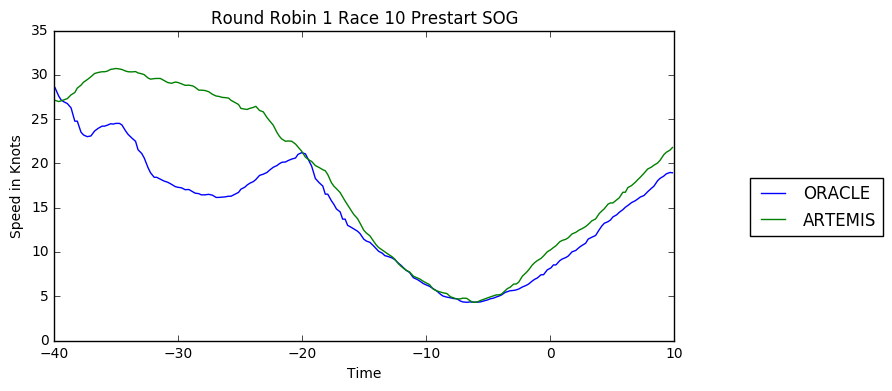

In [33]:
plot_speeds(1,10,-40,10)

In [34]:
def get_marks(rr_number, race_number):
    """
    returns: np array where of rows corresponding to start marks and columns to x, y coordinates for each
    """
    time = get_race_start(rr_number, race_number)
    marks = ["SL1", "SL2"]
    vals = ['x', 'y']
    res = [range(2) for x in range(2)]
    for i,mark in enumerate(marks):
        for j,val in enumerate(vals):
            q = "select TOP 1 V from [AC35].[d].[ACEA.{0}.calculated.{1}] where TS between {2} and {2} + 10000".format(mark, val, time)
            res[i][j] = execute_query(q)[0][0]
    
    return np.array(res)
    

In [36]:
# constants corresponding to the boat dimensions
boatWidth = 8.47
boatLength = 15.00

sternL = [-boatWidth / 2.0, 0.0]
sternR = [boatWidth / 2.0, 0.0]
bowL = [-boatWidth / 2.0, boatLength]
tip = [0.0, boatLength + 5.0]
bowR = [boatWidth / 2.0, boatLength]

boatOrigin = [bowL, tip, bowR, sternR, sternL]


def rotate(theta, pt):
    """
    rotates a point accross the origin by theta radians

    params:
    theta = radians (float)
    pt = [x,y] (floats)

    returns: [new_x, new_y]
    """
    x, y = pt
    cos = np.cos(theta)
    sin = np.sin(theta)
    return [x * cos - y * sin, x * sin + y * cos]


def translate(pt, vec):
    """
    translates a point by vector

    params:
    pt = [x,y]
    vec = [x,y]

    returns: [new_x, new_y]
    """
    pt[0] += vec[0]
    pt[1] += vec[1]
    return pt


def drawBoat(pos, theta):
    """
    Manipulates boatOrigin points to set them at a given position and heading

    params:
    pos = (x,y)
    theta = angle heading (in Radians)

    returns: list of 5 boat corners at position pos with heading = theta
    """
    theta = (theta - np.pi / 2 % (2.0 * np.pi))
    pts = [translate(rotate(theta, x), pos) for x in boatOrigin]
    return pts


In [18]:
def angle_between_points(p1, p2):
    """
    returns angle in degrees between points in 2d 
    """
    d_y = p2[1] - p1[1]
    d_x = p2[0] - p1[0]
    return np.degrees(np.arctan2(d_y, d_x))

In [48]:
def plot_course(rr_number, race_number, start, end, interval_len):
    """
    rr_number: int corresponding to the round robin number
    race_number: int corresponding to the relevant race number
    start: seconds before the start, should be a negative number, must be in (-180, 0)
    end: seconds after the start, should be a positve number, must be in (0, )
    
    interval_len = int to regulate how often to sample data point, should be around 10-20
    
    returns: None, plots trajectories of boats on the starting line
    """
    d = get_positions(rr_number, race_number, start, end)
    b1, b2 = [db_names[i] for i in get_competitor_info(rr_number, race_number)]
        
    xs = d[[b1 + " X", b2 + " X"]].as_matrix()
    ys = d[[b1 + " Y", b2 + " Y"]].as_matrix()

    buff = 25

    mark_data = get_marks(rr_number, race_number)
    mark_xs = mark_data[:,0]
    mark_ys = mark_data[:,1]
    
    xlim=(min(np.concatenate([xs[:,0], xs[:,1], mark_xs]))- buff, 
          max(np.concatenate([xs[:,0], xs[:,1], mark_xs])) + buff)
    ylim=(min(np.concatenate([ys[:,0], ys[:,1], mark_ys]))- buff, 
          max(np.concatenate([ys[:,0], ys[:,1], mark_ys])) + buff)

    plt.figure(figsize=(8,8))
    ax = plt.axes(xlim=xlim, ylim=ylim)
    
    # add starting line
    start_line = plt.Line2D(mark_xs, mark_ys, lw=1., ls='-', marker='.', 
                         markersize=1, 
                         markerfacecolor='w', 
                         markeredgecolor='w',
                         color='black')
    ax.add_line(start_line)
    
    
    # plot lines connecting boats at each time step
    for i in xrange(0, len(xs), interval_len):
        line = plt.Line2D(xs[i], ys[i], lw=1., 
                         ls='-', marker='.', 
                         markersize=1, 
                         markerfacecolor='r', 
                         markeredgecolor='r',
                         markerfacecoloralt='b',
                         color='y')
        ax.add_line(line)
        
    pos1s = d[[b1 + " X", b1 + " Y"]].as_matrix()
    
    pos2s = d[[b2 + " X", b2 + " Y"]].as_matrix()
    
    def get_headings(positions):
        headings = []
        for i in xrange(len(positions) - 1):
            headings.append(angle_between_points(positions[i], positions[i+1]))
        return headings
    
    h1s = get_headings(pos1s)
    h2s = get_headings(pos2s)
    
    
    times = d["Timestep"].as_matrix()

    for i in xrange(0, len(times), interval_len):
        c = 'r'
        if times[i] > 0:
            c = "black"
        ax.annotate(round(times[i]), pos1s[i], size=8, color=c)

    for i in range(0, len(h1s) - 1, interval_len):
        boat1 = plt.Polygon(drawBoat(pos1s[i], np.radians(h1s[i])), color="blue")
        boat2 = plt.Polygon(drawBoat(pos2s[i], np.radians(h2s[i])), color="green")
        
        ax.add_patch(boat1)
        ax.add_patch(boat2)
        
    plt.scatter(mark_data[0][0], mark_data[0][1], color='m')
    plt.scatter(mark_data[1][0], mark_data[1][1], color='c')
    plt.yticks(np.arange(ylim[0], ylim[1], 100.0))
    plt.xticks(np.arange(xlim[0], xlim[1], 100.0))
    
    legend1 = mpatches.Patch(color='blue', label=b1)
    legend2 = mpatches.Patch(color='green', label=b2)
    plt.legend(handles=[legend1, legend2], bbox_to_anchor=(1.35, .55))


    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    plt.title("Round Robin {} Race {} Start Time: {}s to {}s".format(rr_number, race_number, start, end))
    
    plt.show()
    plt.close()

In [44]:
a, b = [i+ 1 for i in range(2)]

In [45]:
a

1

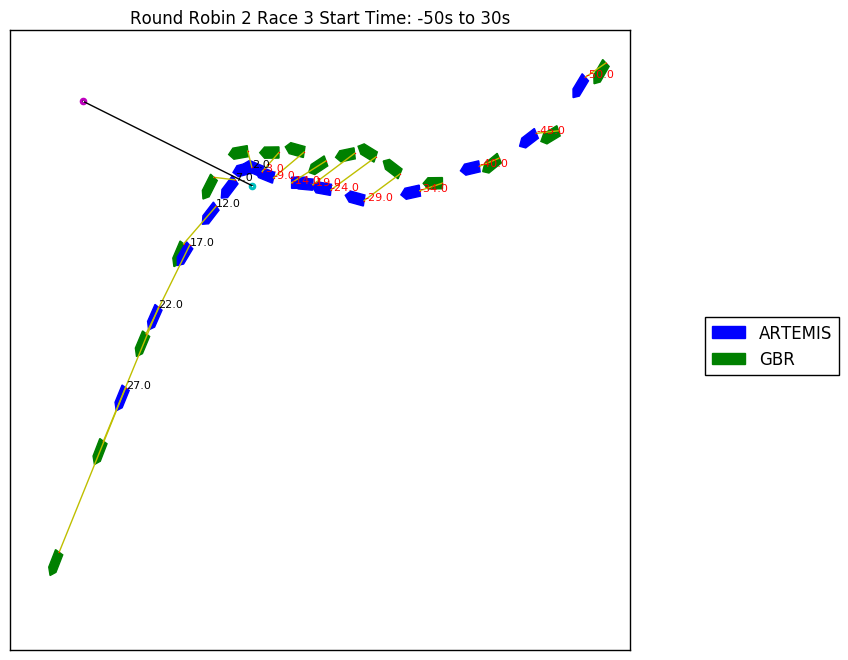

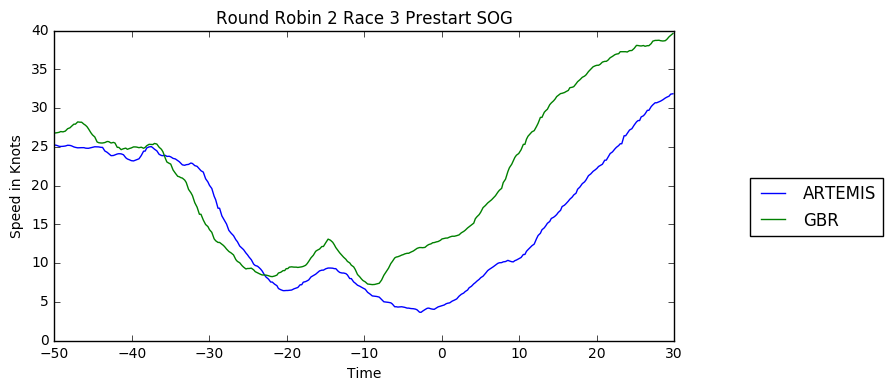

In [49]:
plot_course(2, 3, -50, 30, 20)
plot_speeds(2, 3, -50, 30)